In [281]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.plots as plots
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lecilab_behavior_analysis.df_transforms as dft
from sklearn.linear_model import LogisticRegression
import seaborn as sns
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


single mouse

In [282]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)
# see the available animals
animals = utils.get_animals_in_project(tv_projects[1])
print(animals)
# download the data for a specific animal
mouse = "ACV007"
local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_session_data(
    project_name=tv_projects[1],
    animal=mouse,
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

['COT_test_data', 'visual_and_COT_data']
['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'test', 'test2']
receiving incremental file list

sent 20 bytes  received 69 bytes  25.43 bytes/sec
total size is 96,373,849  speedup is 1,082,852.24


/tmp/ipykernel_13160/1407847157.py:20: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


In [379]:
# reduce the dataset to the psychometric version of the task
# Otherwise, we would include a lot of "easy" trials that would bias the fit
df_test = df[df["current_training_stage"] == "TwoAFC_visual_hard"]

psychometric curve 

/home/kudongdong/lecilab_behavior_analysis/df_transforms.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ratio_col] = df[stim_col].apply(lambda x: abs(eval(x)[0] / eval(x)[1]))
/home/kudongdong/lecilab_behavior_analysis/df_transforms.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ratio_col] = df[ratio_col].apply(np.log).round(4)
/home/kudongdong/lecilab_behavior_analysis/df_transforms.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

<Axes: xlabel='visual_stimulus_ratio', ylabel='left_choice'>

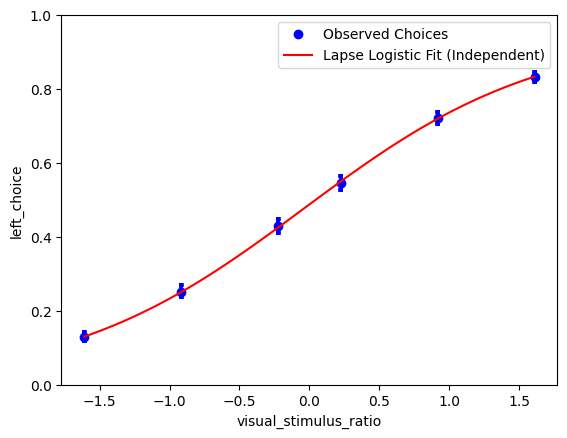

In [289]:
df_test = dft.get_performance_by_difficulty_ratio(df_test)
plots.psychometric_plot_by_discreVal(df_test, x = 'visual_stimulus_ratio', y = 'left_choice')


<Axes: xlabel='visual_stimulus_diff', ylabel='left_choice'>

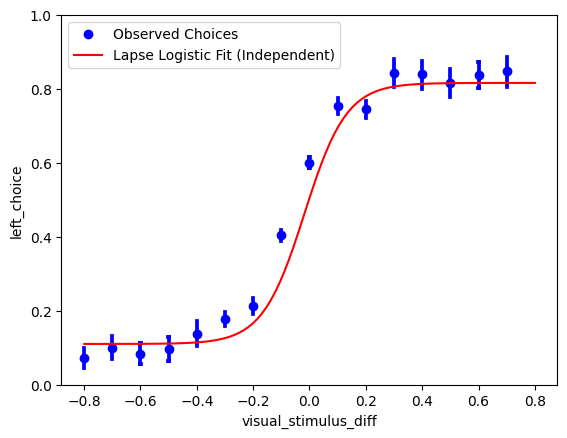

In [290]:
df_test = dft.get_performance_by_difficulty_diff(df_test)
plots.psychometric_plot_by_continuVal(df_test, x = 'visual_stimulus_diff', y = 'left_choice')

GLM comparation

the following cell can be use to evaluate the model. It will be useful when comparing different models

In [237]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.optimize import minimize
import numpy as np

# Define the lapse logistic function with independent lapses for left and right
def lapse_logistic_independent(params, x, y):
    lapse_left, lapse_right, beta, x0 = params
    # Ensure lapse rates are within [0, 0.5]
    lapse_left = np.clip(lapse_left, 0, 0.5)
    lapse_right = np.clip(lapse_right, 0, 0.5)
    # Predicted probabilities
    p_left = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (x - x0)))
    # Negative log-likelihood
    nll = -np.sum(y * np.log(p_left) + (1 - y) * np.log(1 - p_left))
    return nll

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
log_losses = []

# Perform cross-validation
for train_index, test_index in kf.split(df_test):
    # Split the data
    x_train, x_test = df_test['visual_stimulus_ratio'].values[train_index], df_test['visual_stimulus_ratio'].values[test_index]
    y_train, y_test = df_test['left_choice'].values[train_index], df_test['left_choice'].values[test_index]
    
    # Initial parameter guesses: [lapse_left, lapse_right, beta, x0]
    initial_params = [0.05, 0.05, 1, 0]
    
    # Fit the model on the training data
    result = minimize(
        lapse_logistic_independent,
        initial_params,
        args=(x_train, y_train),
        bounds=[(0, 0.5), (0, 0.5), (None, None), (None, None)]
    )
    
    # Extract fitted parameters
    lapse_left, lapse_right, beta, x0 = result.x
    
    # Generate predictions on the test data
    p_left_test = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (x_test - x0)))
    
    # Calculate log loss for the test data
    loss = log_loss(y_test, p_left_test)
    log_losses.append(loss)

# Print cross-validation results
print(f"Cross-Validation Log Losses: {log_losses}")
print(f"Mean Log Loss: {np.mean(log_losses)}")
print(f"Standard ratio of Log Loss: {np.std(log_losses)}")

Cross-Validation Log Losses: [0.5534303513218233, 0.5684063934117124, 0.551883496176922, 0.5697153315150245, 0.560449816252106]
Mean Log Loss: 0.5607770777355177
Standard ratio of Log Loss: 0.0073658145554920335


weight and stats for the different predictors:
- visual stimulus ratio (you call it deviation)
- visual stimulus diff. Nuo: change to "total intensity on left port"
- port where the animal is coming from
- interactions
- Nuo: add another regressor: the previous correct choice

We can play around with this things

In [ ]:
df_new_for_fit = dft.parameters_for_fit(df_test)
results = utils.logi_model_fit(df_new_for_fit, X = ['abs_visual_stimulus_ratio',
                      'previous_port_before_stimulus_numeric',
                      'visual_ratio_diff_interact',
                      'previous_choice_left_correct',
                      'previous_choice_right_wrong',
                      'previous_choice_left', 
                      'visual_ratio_bright_interact'
                          ], y = 'left_choice')

/tmp/ipykernel_13160/3951369888.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mouse_session['correct_side_in_previous'] = df_mouse_session['correct_side'].shift(1, fill_value=np.nan)
/tmp/ipykernel_13160/3951369888.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mouse_session['correct_in_previous'] = df_mouse_session['correct'].shift(1, fill_value=np.nan)
/tmp/ipykernel_13160/3951369888.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Optimization terminated successfully.
         Current function value: 0.607977
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                16791
Model:                          Logit   Df Residuals:                    16783
Method:                           MLE   Df Model:                            7
Date:                Fri, 20 Jun 2025   Pseudo R-squ.:                  0.1223
Time:                        18:44:07   Log-Likelihood:                -10209.
converged:                       True   LL-Null:                       -11631.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
intercept                                -0.7912      

correct choice as output

In [443]:
df_new_for_fit = dft.parameters_for_fit(df_test)
results = utils.logi_model_fit(df_new_for_fit, X = ['abs_visual_stimulus_ratio',
                                                    'wrong_bright', 
                                                    # 'wrong_bright_zscore',
                                                    'same_choice_correctPre', 
                                                    # 'diff_choice_wrongPre', 
                                                    'same_choice_previous', 
                                                    'previous_correct', 
                                                    # 'previous_choice_same_correct'
                                                    ], y = 'correct_numeric')
print(results)

AttributeError: module 'lecilab_behavior_analysis.df_transforms' has no attribute 'parameters_for_fit'

Correct wrong psychometric curve

Text(0.5, 1.0, 'Right Choice Previous')

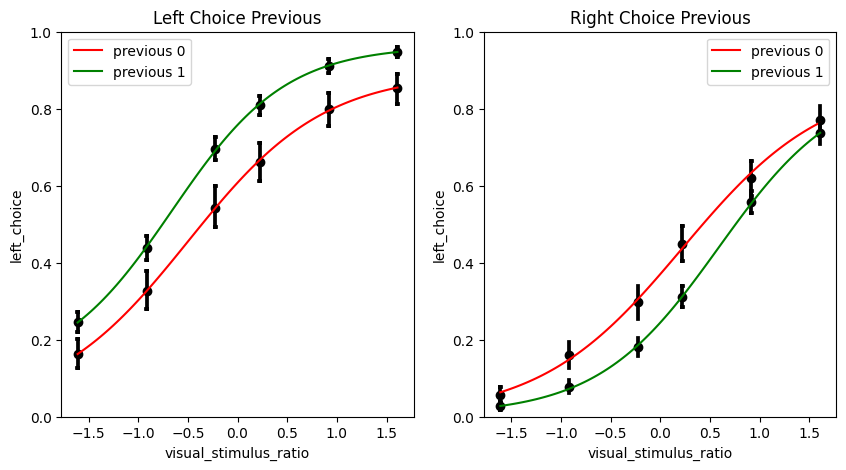

In [259]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_test[df_test['previous_choice'] == 'left'].groupby('previous_correct'), ['red', 'green']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[0],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )

for i, linecolor in zip(df_test[df_test['previous_choice'] == 'right'].groupby('previous_correct'), ['red', 'green']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[1],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )
ax[0].legend()
ax[0].set_title("Left Choice Previous")
ax[1].legend()
ax[1].set_title("Right Choice Previous")

Text(0.5, 1.0, 'Incorrect Choice Previous')

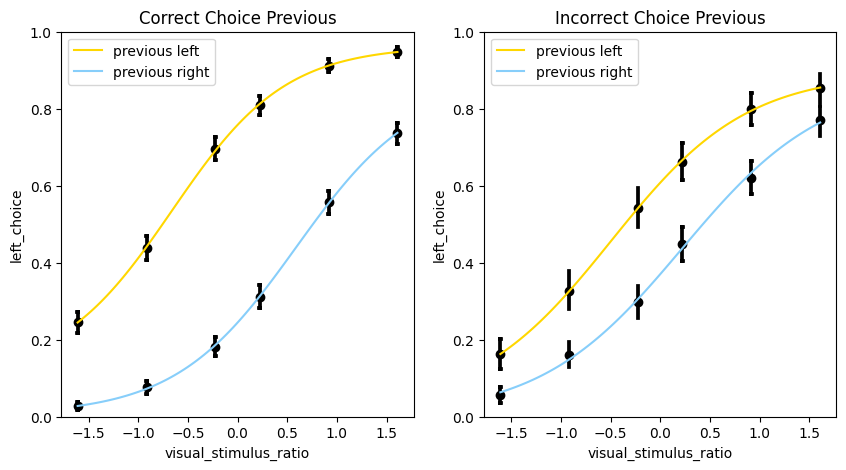

In [260]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, linecolor in zip(df_test[df_test['previous_correct'] == True].groupby('previous_choice'), ['gold', 'lightskyblue']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[0],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )

for i, linecolor in zip(df_test[df_test['previous_correct'] == False].groupby('previous_choice'), ['gold', 'lightskyblue']):
    plots.psychometric_plot_by_discreVal(df = i[1], 
                                         x = 'visual_stimulus_ratio', 
                                         y = 'left_choice', 
                                         ax=ax[1],
                                         markercolor='k',
                                         markers='o',
                                         errorbar=("ci", 95),
                                         markerlabel=None,
                                         markersize=5, 
                                         linecolor=linecolor, 
                                         linelabel='previous ' + str(i[0])
                                        )
ax[0].legend()
ax[0].set_title("Correct Choice Previous")
ax[1].legend()
ax[1].set_title("Incorrect Choice Previous")

Matrix format

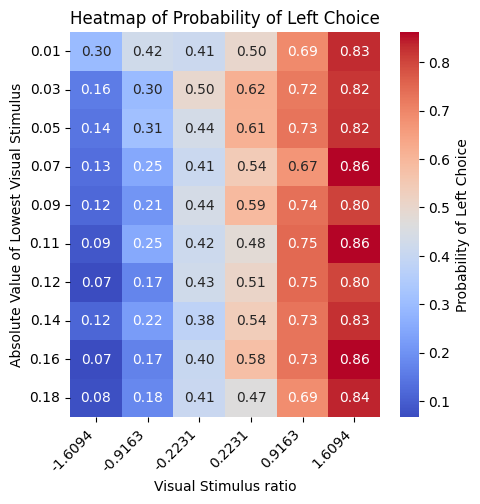

In [261]:
# let's use the absolute value of the lowest visual stimulus as a proxy for the brightness of the visual stimulus
df_test['visual_stimulus_lowest'] = df_test['visual_stimulus'].apply(lambda x: abs(eval(x)[0]) if eval(x)[0] < eval(x)[1] else abs(eval(x)[1]))
# create 10 bins for the absolute value of the lowest visual stimulus
min_value = df_test['visual_stimulus_lowest'].min()
max_value = df_test['visual_stimulus_lowest'].max()
bins = np.linspace(min_value, max_value, 11)
df_test['visual_stimulus_lowest_binned'] = pd.cut(df_test['visual_stimulus_lowest'], bins=bins, labels=[f"{b:.2f}" for b in bins[:-1]])
# create a pivot table with the visual stimulus ratio and absolute value of the lowest visual stimulus
pivot_table_abs = df_test.pivot_table(
    index='visual_stimulus_lowest_binned',
    columns='visual_stimulus_ratio',
    values='left_choice',
    aggfunc='mean',
    observed=True
)
# plot the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(pivot_table_abs, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Probability of Left Choice'})
plt.xlabel("Visual Stimulus ratio")
plt.ylabel("Absolute Value of Lowest Visual Stimulus")
plt.title("Heatmap of Probability of Left Choice")
# rotate the y-axis labels
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.show()

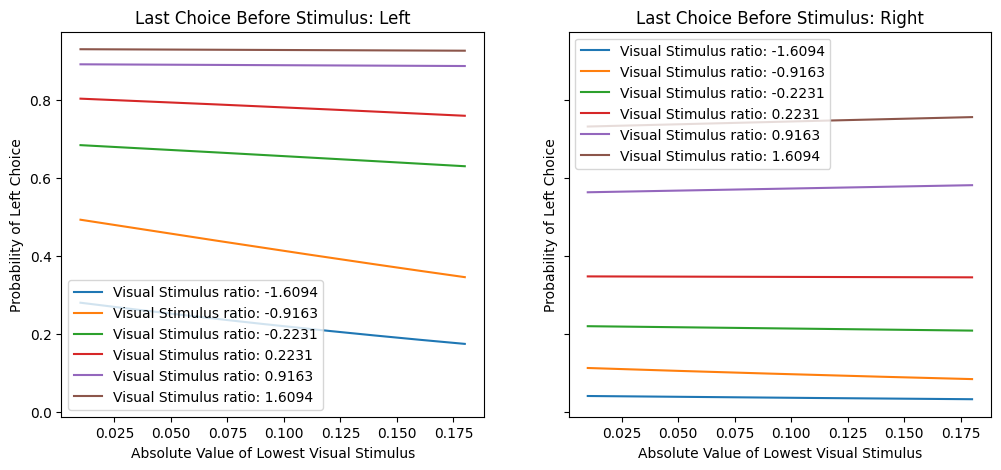

In [262]:
# transform visual_stimulus_lowest_binned to a numeric value for plotting
df_test['visual_stimulus_lowest_binned_num'] = pd.to_numeric(df_test['visual_stimulus_lowest_binned'], errors='coerce')

# make two plots, one for when the animals comes from the left and one for when it comes from the right
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# Plot for when the animal comes from the left
for ax, side in zip(axs.ravel(), ['left', 'right']):
    df_side = df_test[df_test['previous_port_before_stimulus'] == side]
    for i in df_side.groupby('visual_stimulus_ratio'):
        df_i = i[1].sort_values(by='visual_stimulus_lowest_binned_num')
        # drop nan
        df_i = df_i.dropna(subset=['visual_stimulus_lowest_binned_num'])
        X = df_i['visual_stimulus_lowest_binned_num'].values.reshape(-1, 1)
        y = df_i['left_choice'].values.astype(int)
        model = LogisticRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:, 1]
        ax.plot(X, y_prob, label=f"Visual Stimulus ratio: {i[0]}")
    ax.set_xlabel("Absolute Value of Lowest Visual Stimulus")
    ax.set_ylabel("Probability of Left Choice")
    ax.legend()
    ax.set_title(f"Last Choice Before Stimulus: {side.capitalize()}")
plt.show()

Fit the lapse model independently considering previous choices

Side: left, Lapse Left: 0.07815923247195643, Lapse Right: 0.051582941374243345, Slope (Beta): 1.6554336972666035, PSE (x0): -0.6424372946891975
Side: right, Lapse Left: 0.0025675704590622716, Lapse Right: 0.10333113302183851, Slope (Beta): 1.4849436752942449, PSE (x0): 0.5434352426404494


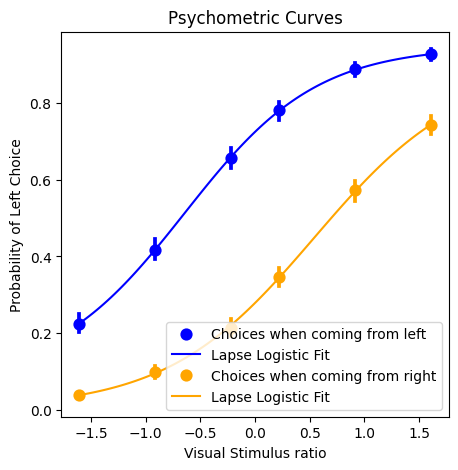

In [263]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

colors = ["blue", "orange"]

for color, side in zip(colors, ['left', 'right']):
    df_side = df_test[df_test['previous_port_before_stimulus'] == side]
    # Fit the model
    x = df_side['visual_stimulus_ratio'].values
    y = df_side['left_choice'].values
    result = minimize(
        lapse_logistic_independent,
        initial_params,
        args=(x, y),
        bounds=[(0, 0.5), (0, 0.5), (None, None), (None, None)]
    )

    # Extract fitted parameters
    lapse_left, lapse_right, beta, x0 = result.x
    print(f"Side: {side}, Lapse Left: {lapse_left}, Lapse Right: {lapse_right}, Slope (Beta): {beta}, PSE (x0): {x0}")

    # Generate predictions
    xs = np.linspace(df_side['visual_stimulus_ratio'].min(), df_side['visual_stimulus_ratio'].max(), 100)
    p_left = lapse_left + (1 - lapse_left - lapse_right) / (1 + np.exp(-beta * (xs - x0)))

    # Plot the fitted curve

    sns.pointplot(
        x='visual_stimulus_ratio',
        y='left_choice',
        data=df_side,
        estimator=lambda x: np.mean(x),
        color=color,
        markers='o',
        errorbar=("ci", 95),
        ax=ax,
        label=f'Choices when coming from {side}',
        native_scale=True,
        linestyles='',
    )
    ax.plot(xs, p_left, color=color, label='Lapse Logistic Fit')
    ax.set_xlabel("Visual Stimulus ratio")
    ax.set_ylabel("Probability of Left Choice")
    plt.title(f"Psychometric Curves")
    ax.legend()
plt.show()

I kept what you did for comparison here

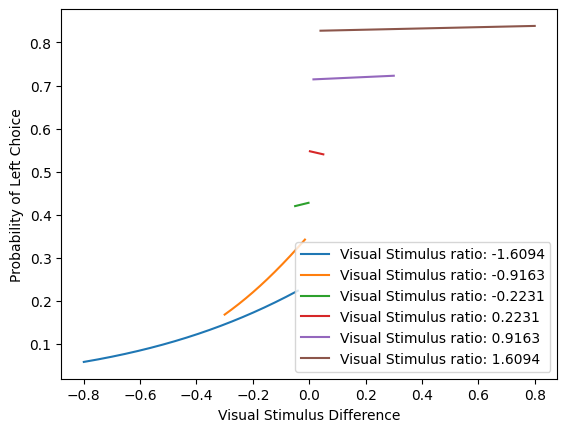

In [264]:
# It is interesting to compare the effects of the relative difference between the two visual stimuli,
# and the absolute difference between them.

# Maybe what we can do is to train another logistic regression model, adding as well the absolute difference
# between the two visual stimuli, and see how it affects the probability of a left choice.
# Do you know what I mean?

for i in df_test.groupby('visual_stimulus_ratio'):
    df_i = i[1].sort_values(by='visual_stimulus_diff')
    X = df_i['visual_stimulus_diff'].values.reshape(-1, 1)
    y = df_i['left_choice'].values.astype(int)
    model = LogisticRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    plt.plot(X, y_prob, label=f"Visual Stimulus ratio: {i[0]}")
    plt.legend()
plt.xlabel("Visual Stimulus Difference")
plt.ylabel("Probability of Left Choice")
plt.show()

Multiple animals analysis


In [265]:
df_dic = {}
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_session_data(
        project_name=tv_projects[1],
        animal=mouse,
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )
    # load the data
    df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

receiving incremental file list
ACV001.csv

sent 76,963 bytes  received 4,517,280 bytes  296,402.77 bytes/sec
total size is 149,046,177  speedup is 32.44


/tmp/ipykernel_13160/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV002.csv

sent 78,006 bytes  received 2,754,755 bytes  333,266.00 bytes/sec
total size is 144,963,955  speedup is 51.17


/tmp/ipykernel_13160/3744723000.py:14: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV003.csv

sent 75,269 bytes  received 2,004,717 bytes  244,704.24 bytes/sec
total size is 128,004,262  speedup is 61.54


/tmp/ipykernel_13160/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV004.csv

sent 64,975 bytes  received 1,522,629 bytes  42,336.11 bytes/sec
total size is 95,737,937  speedup is 60.30


/tmp/ipykernel_13160/3744723000.py:14: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV005.csv

sent 62,770 bytes  received 2,154,771 bytes  341,160.15 bytes/sec
total size is 93,876,090  speedup is 42.33


/tmp/ipykernel_13160/3744723000.py:14: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV006.csv

sent 68,780 bytes  received 1,051,773 bytes  149,407.07 bytes/sec
total size is 103,027,688  speedup is 91.94


/tmp/ipykernel_13160/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list

sent 20 bytes  received 69 bytes  35.60 bytes/sec
total size is 96,373,849  speedup is 1,082,852.24


/tmp/ipykernel_13160/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV008.csv

sent 77,656 bytes  received 2,058,895 bytes  224,900.11 bytes/sec
total size is 138,211,676  speedup is 64.69


/tmp/ipykernel_13160/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV009.csv

sent 76,998 bytes  received 3,241,299 bytes  316,028.29 bytes/sec
total size is 141,306,326  speedup is 42.58


/tmp/ipykernel_13160/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list
ACV010.csv

sent 71,748 bytes  received 2,969,907 bytes  320,174.21 bytes/sec
total size is 123,766,354  speedup is 40.69


/tmp/ipykernel_13160/3744723000.py:14: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dic[mouse] = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


receiving incremental file list

sent 20 bytes  received 71 bytes  60.67 bytes/sec
total size is 409,338  speedup is 4,498.22
receiving incremental file list

sent 20 bytes  received 72 bytes  36.80 bytes/sec
total size is 7,152  speedup is 77.74


In [266]:
df_dic_hard = {}
for df_name, df in zip(df_dic.keys(), df_dic.values()):
    if 'TwoAFC_visual_hard' in df["current_training_stage"].unique():
        df = df.dropna(subset = ['visual_stimulus'])
        df = df[df["current_training_stage"] == "TwoAFC_visual_hard"]

        df['visual_stimulus_ratio'] = df['visual_stimulus'].apply(lambda x: abs(round(eval(x)[0] / eval(x)[1], 4)))
        df['visual_stimulus_ratio'] = df.apply(
            lambda row: row['visual_stimulus_ratio'] if row['correct_side'] == 'left' else -row['visual_stimulus_ratio'],
            axis=1
        )
        df['visual_stimulus_diff'] = df['visual_stimulus'].apply(lambda x: abs(eval(x)[0] - eval(x)[1]))
        df['visual_stimulus_diff'] = df.apply(
            lambda row: row['visual_stimulus_diff'] if row['correct_side'] == 'left' else -row['visual_stimulus_diff'],
            axis=1
        )
        df["visual_stimulus_diff_binned"] = df['visual_stimulus_diff'] // 0.1
        df = dft.add_mouse_first_choice(df)
        df['left_choice'] = df['first_choice'].apply(lambda x: 1 if x == 'left' else 0)
        
        df_dic_hard[df_name] = df

In [267]:
df_ratio_diffBin_inter_p = pd.DataFrame()
df_ratio_diffBin_inter_coef = pd.DataFrame()
for df_name, df in zip(df_dic_hard.keys(), df_dic_hard.values()):
    df['interaction_term'] = df.apply(interaction_calc, axis=1)
    # Prepare the independent variables
    X_multi = df[['visual_stimulus_ratio', 'visual_stimulus_diff_binned', 'interaction_term']]
    X_multi_const = sm.add_constant(X_multi)
    y = df['left_choice'].values.astype(int)

    # Fit the logistic regression model with multiple regressors
    logit_model_multi = sm.Logit(y, X_multi_const).fit()

    df_ratio_diffBin_inter_p[df_name] = logit_model_multi.pvalues
    df_ratio_diffBin_inter_coef[df_name] = logit_model_multi.params

Optimization terminated successfully.
         Current function value: 0.623824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.587048
  

In [268]:
df_ratio_diff_inter_p = pd.DataFrame()
df_ratio_diff_inter_coef = pd.DataFrame()
for df_name, df in zip(df_dic_hard.keys(), df_dic_hard.values()):
    df['interaction_term'] = df.apply(interaction_calc, axis=1)
    # Prepare the independent variables
    X_multi = df[['visual_stimulus_ratio', 'visual_stimulus_diff', 'interaction_term']]
    X_multi_const = sm.add_constant(X_multi)
    y = df['left_choice'].values.astype(int)

    # Fit the logistic regression model with multiple regressors
    logit_model_multi = sm.Logit(y, X_multi_const).fit()

    df_ratio_diff_inter_p[df_name] = logit_model_multi.pvalues
    df_ratio_diff_inter_coef[df_name] = logit_model_multi.params

Optimization terminated successfully.
         Current function value: 0.623629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.586577
  

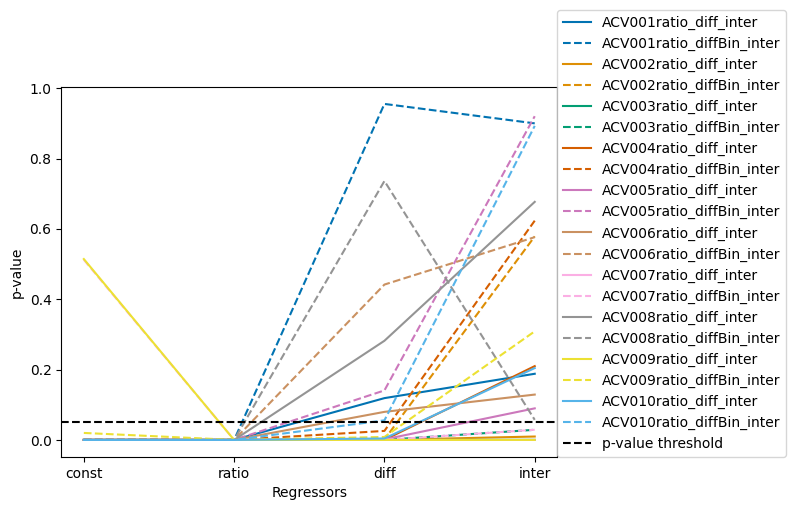

In [269]:
df_ratio_diffBin_inter_p.rename(index={'visual_stimulus_ratio': 'ratio', 'visual_stimulus_diff_binned': 'diff', 'interaction_term': 'inter'}, inplace=True)
df_ratio_diff_inter_p.rename(index={'visual_stimulus_ratio': 'ratio', 'visual_stimulus_diff': 'diff', 'interaction_term': 'inter'}, inplace=True)
for df_name, color in zip(df_dic_hard.keys(), sns.color_palette("colorblind", len(df_dic_hard))):
    plt.plot (df_ratio_diff_inter_p[df_name], label=df_name+ 'ratio_diff_inter', color=color)
    plt.plot (df_ratio_diffBin_inter_p[df_name], label=df_name+ 'ratio_diffBin_inter', color=color, linestyle='--')
plt.axhline(y=0.05, color='k', linestyle='--', label='p-value threshold')
plt.xlabel("Regressors")
plt.ylabel("p-value")
plt.legend(loc = (1 , 0))

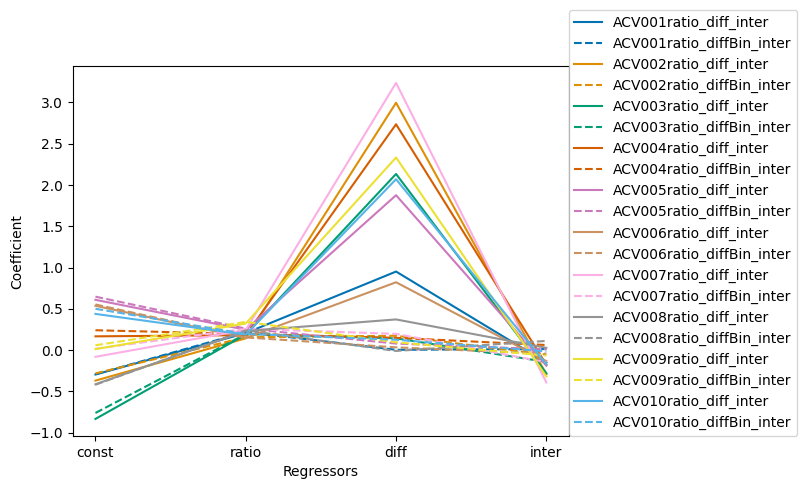

In [270]:
df_ratio_diffBin_inter_coef.rename(index={'visual_stimulus_ratio': 'ratio', 'visual_stimulus_diff_binned': 'diff', 'interaction_term': 'inter'}, inplace=True)
df_ratio_diff_inter_coef.rename(index={'visual_stimulus_ratio': 'ratio', 'visual_stimulus_diff': 'diff', 'interaction_term': 'inter'}, inplace=True)
for df_name, color in zip(df_dic_hard.keys(), sns.color_palette("colorblind", len(df_dic_hard))):
    plt.plot (df_ratio_diff_inter_coef[df_name], label=df_name+ 'ratio_diff_inter', color=color)
    plt.plot (df_ratio_diffBin_inter_coef[df_name], label=df_name+ 'ratio_diffBin_inter', color=color, linestyle='--')
plt.xlabel("Regressors")
plt.ylabel("Coefficient")
plt.legend(loc = (1 , 0))